## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

In this project, we will try to understand the results of an A/B test run by an e-commerce website. We will help the company to understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability


In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [4]:
# Checking top few rows in the data
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
# Checking the number of rows in data
df.shape

(294478, 5)

In [6]:
# Identifying unique users in data
df['user_id'].nunique()

290584

In [7]:
# Identifying the proportion of users converted
df['converted'].mean()

0.11965919355605512

In [17]:
# Query to find out the number of times mismatch
query1 = df.query('group == "treatment" & landing_page == "old_page"').count()
query2 = df.query('group == "control" & landing_page == "new_page"').count()
total = query1 + query2
total

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

In [8]:
# Identifying missing values in data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [5]:
# Creating new dataframe based on qury result
df2 = df.query("(group == 'control' & landing_page == 'old_page') or (group == 'treatment' & landing_page == 'new_page')")

In [19]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [21]:
# Identifying unique users in data
df2['user_id'].nunique()

290584

In [24]:
# Identifying duplicate user
user = df2['user_id']
duplicate_user = df2[user.isin(user[df2['user_id'].duplicated()])]
duplicate_user

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [31]:
# Getting row information for duplicate user_id
print(df2.loc[df2['user_id'] == 773192])

      user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


In [32]:
# Removing one of the duplicate
df2.drop(2893, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [33]:
# Identifying the probability of an individual converting for any page
df2['converted'].mean()

0.11959708724499628

In [38]:
# Identifying probability of converted in control group
df2.query("group == 'control'")['converted'].mean()

0.1203863045004612

In [39]:
# Identifying probability of converted in treatment group
df2.query("group == 'treatment'")['converted'].mean()

0.11880806551510564

In [37]:
# Identifying propbability for an individual received the new page
df2.query("landing_page == 'new_page'").shape[0] / df2.shape[0]

0.5000619442226688

We can see that the probability of conversion is 11.9% regardless of page. 
When individual was in control group, it increases to 12% whereas it decreases to 11.8% for treatment group.
It looks like converion is slightly in favor of control page.

<a id='ab_test'></a>
### Part II - A/B Test

To assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, the null and alternative hypotheses in terms of **$p_{old}$** and **$p_{new}$**, as below

$$ H_{0}: P_{new} - P_{old} <= 0 $$
$$ H_{1}: P_{new} - P_{old} > 0 $$

Performing the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

In [7]:
# Conversion rate for P_new
P_new = df2['converted'].mean()
P_new

0.11959667567149027

In [8]:
# Conversion rate for P_old
P_old = df2['converted'].mean()
P_old

0.11959667567149027

In [10]:
# Identifying the number of individuals in treatment group
n_new = df2.query("group == 'treatment'")['user_id'].count()
n_new

145311

In [11]:
# Identifying the number of individuals in control group
n_old = df2.query("group == 'control'")['user_id'].count()
n_old

145274

In [12]:
# Simulating n_new transactions with probability as P_new
new_page_converted = np.random.binomial(1, P_new, n_new)
new_page_converted

array([1, 0, 0, ..., 0, 0, 0])

In [13]:
# Simulating n_old transactions with probability as P_old
old_page_converted = np.random.binomial(1, P_old, n_old)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

In [19]:
# Observing the simulated difference
obs_diff = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()
simulate_diff = new_page_converted.mean() - old_page_converted.mean()
simulate_diff

-0.0013312507592458944

In [20]:
# Sampling distribution with bootstratpping
diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(1, P_new, n_new)
    old_page_converted = np.random.binomial(1, P_old, n_old)
    simulate_diff = new_page_converted.mean() - old_page_converted.mean()
    diffs.append(simulate_diff)

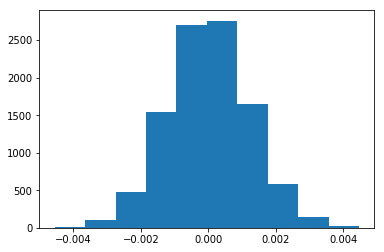

In [21]:
# Plotting a sampling distribution
diffs = np.array(diffs)
plt.hist(diffs);

In [22]:
# Computing P value
null_vals = np.random.normal(0, diffs.std(), diffs.size)
(null_vals > obs_diff).mean()

0.90100000000000002

Here, we've computed P value. This is the probability of observing statistic if the null hypothesis is true. As we get the P-value as 0.90 (p > 0.05), which gives an evidence that there is no need to reject null hypothesis and old page is perfectly doing it's job.

#### Using a built-in to achieve similar results. Calculating the number of conversions for each page, as well as the number of individuals who received each page.

In [23]:
# Calculating number of converions for each page and for individuals who received each page
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" & converted == "1"')['converted'].count()
convert_new = df2.query('landing_page == "new_page" & converted == "1"')['converted'].count()
n_old = df2.query("landing_page == 'old_page'")['user_id'].count()
n_new = df2.query("landing_page == 'new_page'")['user_id'].count()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Using `stats.proportions_ztest` to compute test statistic and p-value.

In [24]:
# Computing P value
from statsmodels.stats.proportion import proportions_ztest
z_stat , p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_stat, p_value

(1.3116075339133115, 0.90517370514059103)

We got the z-score as 1.3 which is between -2 and -2, i.e, about 95% as per the Emperical rule or the 68-95-99.7 Rule. The p-value also gave the same result, i.e, 0.9 (90%) which indicates that we have an evidence that there is no need to reject null hypothesis and old page is perfectly doing it's job.

<a id='regression'></a>
### Part III - A regression approach

Identifying that the result achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

The logistic regression will be suitable here, as it predicts a probability between 0 and 1, i.e, categorical data with only two outcomes.

In [9]:
# Creating a dummy variable columns
df2['intercept'] = 1
df2['ab_page'] = (df2.group == 'treatment').astype(int)
df2.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [10]:
# Instantiating a regression model
import statsmodels.api as sm
log_model = sm.Logit(df2.converted, df2[['intercept', 'ab_page']])

In [9]:
# Fitting the model to get the summry result
result = log_model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-08-30 03:31 AIC:              212780.6032
No. Observations:   290585           BIC:              212801.7625
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290583           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3116  0.1897  -0.0374   0.0074
==================================================================

"""

The p-value associated with ab_page is 0.18 which differs from the value we got previously because of the difference in null and alternative hypothesis association. Earlier, we've performed one-sided test but in regression, the test was two-sided.

The hypothesis we considered previously as below:

$$ H_{0}: P_{new} - P_{old} <= 0 $$
$$ H_{1}: P_{new} - P_{old} > 0 $$

The hypothesis we considered for the regression analysis is either a conversion or no conversion, as below:

$$ H_{0}: P_{new} - P_{old} = 0 $$
$$ H_{1}: P_{new} - P_{old} ≠ 0 $$

Here, the p-value under null hypothesis assumes that new page has no corelation with response varible, but this is greater than the type 1 error rate (0.18 > 0.05). This indicates that we have an evidence that there is no need to reject null hypothesis and old page is perfectly doing it's job.

#### Is it a good idea to consider other factors to add into regression model. Are there any disadvantages to adding additional terms into regression model?

The p-value for ab_page (0.18) is greater than the common alpha level of 0.05, which indicates that it is not statistically significant, so we need to consider other variables that might influence the conversion.

We need to analyze r-squared together with other variables to draw conclusion about model. As the quality of the statistical measure depends on factors, such as the nature of the variables employed, the units of measure of the variables, hence, a high r-squared sometimes can indicate the problems with the regression model.

#### To find out if the conversion rate changes for different pages, adding an effect based on which country a user lives in by merging **countries.csv** dataset on the appropriate rows.

In [14]:
# Checking top few rows in the country data
country_df = pd.read_csv('countries.csv')
df3 = pd.merge(df2, country_df, how='inner', on=['user_id'])
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [15]:
df3['country'].value_counts()

US    203620
UK     72466
CA     14499
Name: country, dtype: int64

In [16]:
# Creating dummy variables
df3[['US', 'UK', 'CA']] = pd.get_dummies(df3['country'])
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,US,UK,CA
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [17]:
# Instantiating a regression model
import statsmodels.api as sm

df3['intercept'] = 1
log_model = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'US', 'UK']])
result = log_model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-08-30 13:12 AIC:              212781.3782
No. Observations:   290585           BIC:              212823.6968
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7629  0.0000  -2.0067  -1.9718
ab_page      -0.0150    0.0114    -1.3076  0.1910  -0.0374   0.0075
US           -0.0408    0.0269    -1.5159  0.1296  -0.0934   0.0119
UK            0.0099    0.0133     0.7437  0.4570  -0.0162   0.0359
==================================================================

"""

The p-values we got with the help of Logit model are higher than the common alpha level of 0.05, which indicates that variables are not statistically significant. The countries we have added here had no impact on conversion. This indicates that we have an evidence that there is no need to reject null hypothesis and old page is perfectly doing it's job.

#### Looking at an interaction between page and country to see if there is a significant effects on conversion.

In [18]:
# Instantiating a regression model
import statsmodels.api as sm

df3['ab_US'] = df3['ab_page'] * df3['US']
df3['ab_UK'] = df3['ab_page'] * df3['UK']

log_model = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'US', 'UK', 'ab_US', 'ab_UK']])
result = log_model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366108
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-08-30 13:12 AIC:              212782.9124
No. Observations:   290585           BIC:              212846.3903
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290579           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5060  0.1321  -0.0474   0.0062
US           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
ab_US        -0.0469    0.0538    -0.8716  0.3834  -0.1523   0.0585
ab_UK         0.0314    0.0266     1.1811  0.2375  -0.0207   0.0835
==================================================================

"""

The p-values we got in the result are higher than the error rate of .05. This shows that an interaction between page and country does not make any significant effect on converion. This indicates that there is no need to reject null hypothesis and old page is perfectly doing it's job.

<a id='conclusions'></a>
## Conclusion

In this project, we analysed the data to find out p-values using different methods. This analysis shows that the old page is performing better as compared with the new page. Hence, we accept the Null Hypothesis and Reject the Alternate Hypothesis.